# The purpose of this notebook is to get more knowledge about these datasets

In [123]:
## run with eda_env 
##TODO - EDA -> try to build features by heuristics and then build model ?? -> super easy and cool
##TODO -> Get to know data better. Actually data analysis is where we should start

N = 10 # number of most common words/n-grams to rank
ngram = 3 # number of elements in n-gram

Pomysly:
- Ilość wielkich liter w tytulach z clickbaitami do wilekich liter z prawdziwymi artykulami oraz Analiza znakow interpunkcyjnych
- stopwords in articles and titles

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import string
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
import spacy
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import string

## Most occuring words in clickbaits and no-clikbaits

In [125]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")

In [126]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42,
    stratify=df_merged["clickbait"]
)

In [127]:
x_train_clickbait = x_train[y_train==1]
x_train_no_clickbait = x_train[y_train==0]

In [128]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
def get_most_common_words(x_train):
    """
    finds most common word
    """
    words = x_train.str.split().explode().tolist()
    words_no_stop_words = [word.lower() for word in words if word.lower() not in stop_words]
    counter = Counter(words_no_stop_words)
    most_common_words = counter.most_common(N)
    return most_common_words

In [130]:
x_train_clickbait = x_train_clickbait.apply(lambda x: remove_punctuation(x))
x_train_no_clickbait = x_train_no_clickbait.apply(lambda x: remove_punctuation(x))
df_clibkaits = pd.DataFrame(get_most_common_words(x_train_clickbait), columns=['Word', 'Frequency'])
df_NO_clibkaits = pd.DataFrame(get_most_common_words(x_train_no_clickbait), columns=['Word', 'Frequency'])

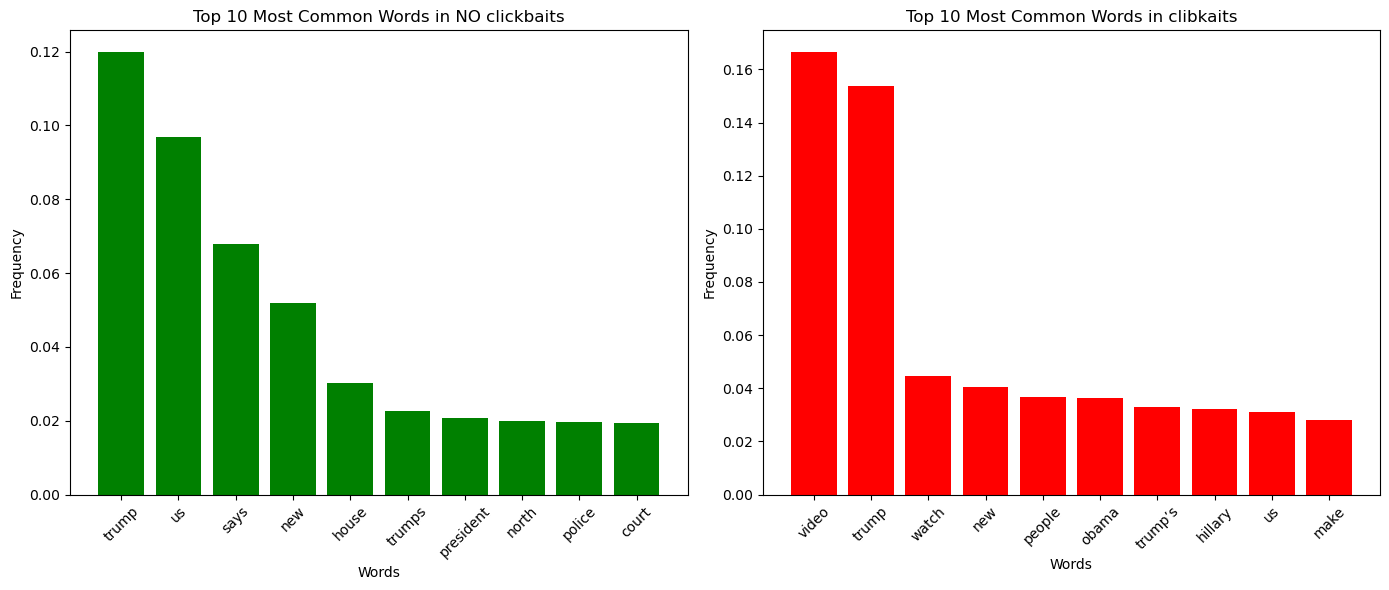

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(df_NO_clibkaits['Word'], df_NO_clibkaits['Frequency']/x_train_no_clickbait.shape[0], color='green')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Top {N} Most Common Words in NO clickbaits')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(df_clibkaits['Word'], df_clibkaits['Frequency']/x_train_clickbait.shape[0], color='red')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Top {N} Most Common Words in clibkaits')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Both clickbait articles and no-clickbait articles frequently refers to politics. As a difference between them is a "video" frequently mentioned in clickbait titles to tempt potential users.

### N-grams Analysis

Sequence of "n" adjacent symbols or the words found in a language dataset in particular order.

In [132]:
def remove_punctuation(text):
  """
  Removes punctuation
  """
  if(type(text)==float):
    return text
  res=""  
  for i in text:     
    if i not in string.punctuation:
      res+=i    
  return res

In [133]:
def generate_N_grams(text, ngram=1):
    """
    Function generates n-gram
    """
    words=[word.lower() for word in text.split() if word not in set(stopwords.words('english'))]
    temp=zip(*[words[i:] for i in range(0,ngram)])
    res=[' '.join(ngram) for ngram in temp]
    return res

In [134]:
def get_ngram_frequencies(df, ngram=1):
    """
    calculate frequencies of n-grams
    """
    df["n-gram"] = df["title"].apply(lambda x: generate_N_grams(x, ngram))
    all_ngrams = [ngram for sublist in df["n-gram"] for ngram in sublist]
    ngram_counts = Counter(all_ngrams)
    return pd.DataFrame(ngram_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [151]:
sa_train_merged = train_merged
sa_train_merged["title"] = sa_train_merged["title"].apply(lambda x: remove_punctuation(x))

df_clickbait_0 = sa_train_merged.loc[sa_train_merged['clickbait'] == 0]
df_clickbait_0 = get_ngram_frequencies(df_clickbait_0, ngram=ngram)

df_clickbait_1 = sa_train_merged.loc[sa_train_merged['clickbait'] == 1]
df_clickbait_1 = get_ngram_frequencies(df_clickbait_1, ngram=ngram)

C:\Users\wojom\AppData\Local\Temp\ipykernel_34072\4032746761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n-gram"] = df["title"].apply(lambda x: generate_N_grams(x, ngram))
C:\Users\wojom\AppData\Local\Temp\ipykernel_34072\4032746761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n-gram"] = df["title"].apply(lambda x: generate_N_grams(x, ngram))


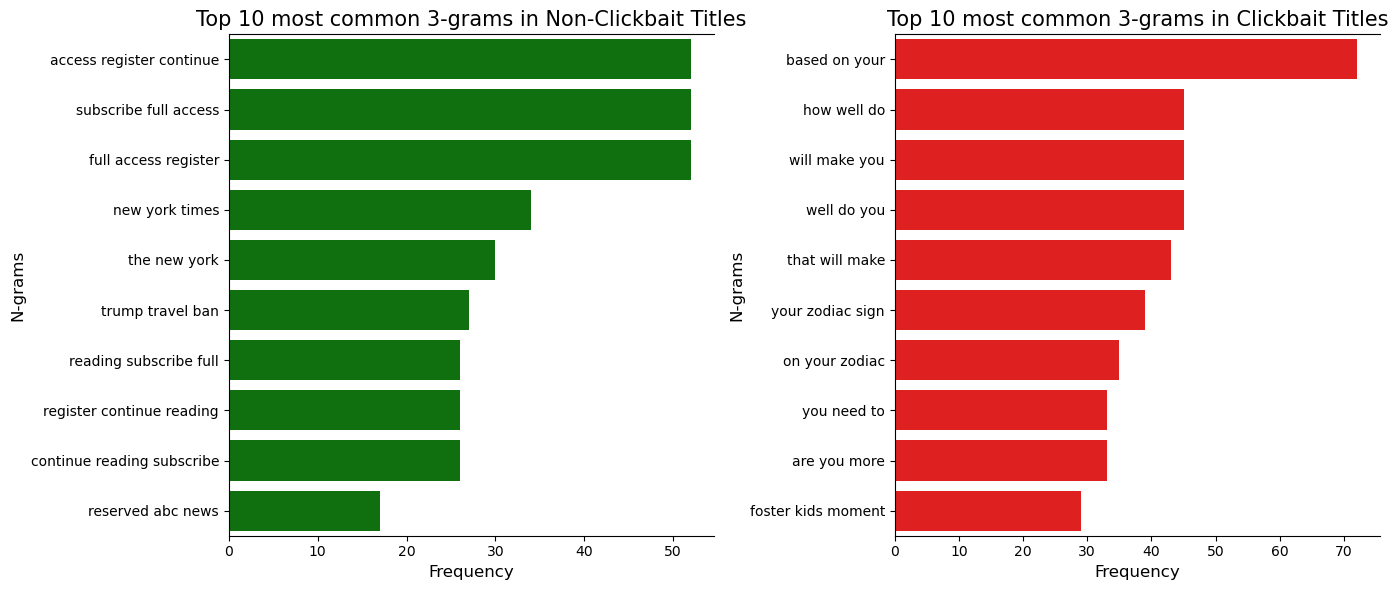

In [195]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

sns.barplot(y=df_clickbait_0['Word'].values[:N], x=df_clickbait_0['Frequency'].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_clickbait_1['Word'].values[:N], x=df_clickbait_1['Frequency'].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('Frequency', fontsize=12)
    axes[i].set_ylabel('N-grams', fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

axes[0].set_title(f'Top {N} most common {ngram}-grams in Non-Clickbait Titles', fontsize=15)
axes[1].set_title(f'Top {N} most common {ngram}-grams in Clickbait Titles', fontsize=15)

plt.tight_layout()
plt.show()

3-grams analysis shows that the word "subscription" is common in non-clickbait sources. It makes sense since paid sources should be more trustfull. Clickbait titles use names of popular organisations like "Black Lives Matter". They try to drive reader's attention by addressing highly personal information by "based on your", "your zodiac sign", or giving advices: "you need to".

## Named Entity Recognition (NER)
NER identifies predefined categories of words in sentences.

### Example:
*John Smith uses iPhone 11 while going to Toronto.*

- **John Smith** - Person
- **iPhone 11** - Product
- **Toronto** - Location

In [188]:
train_merged = pd.DataFrame({"title":x_train, "clickbait":y_train})
ner_train_merged = train_merged

In [189]:
def extract_named_entities(text):
    """
    Extracts entities from text. Returns dictionary with the count of each entity type.
    """
    doc = nlp(text)
    entities = {}
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_] += 1
        else:
            entities[entity.label_] = 1.0
    return entities


In [190]:
# This cell executes up to ~3min
nlp = spacy.load('en_core_web_sm')
num_clickbaits = len(ner_train_merged.loc[ner_train_merged["clickbait"]==0])
num_no_clickbaits = len(ner_train_merged.loc[ner_train_merged["clickbait"]==1])
extracted_entities = ner_train_merged["title"].apply(extract_named_entities)
entities_df = pd.DataFrame(list(extracted_entities))
ner_train_merged = ner_train_merged[["clickbait"]].join(entities_df).fillna(0.0)
grouped = ner_train_merged.groupby("clickbait").sum()
grouped = grouped.transpose()
grouped_copy = grouped
grouped[1] = grouped[1]/num_clickbaits
grouped[0] = grouped[0]/num_no_clickbaits

In [191]:
def classify(row):
    """
    vote for the option where the measurement is greater by 5%
    """
    if row[0]/row[1] > 1.05:
        return 0
    elif row[1]/row[0] > 1.05:
        return 1
    else:
        return 0.5

In [192]:
# ordering
grouped["total"] = grouped[0] + grouped[1]

# classification of entities as clickbait supportive or not
grouped["class"] = grouped.apply(classify, axis=1)
grouped = grouped.sort_values("total", ascending=False)
print(f"Clickbait supportive: {grouped.index[grouped['class'] == 1].to_list()}")
print(f"Neutral: {grouped.index[grouped['class'] == 0.5].to_list()}")
print(f"Valid article supportive: {grouped.index[grouped['class'] == 0].to_list()}")
grouped = grouped.drop(columns=["total", "class"])

Clickbait supportive: ['PERSON', 'CARDINAL', 'WORK_OF_ART', 'MONEY', 'EVENT', 'LAW']
Neutral: []
Valid article supportive: ['ORG', 'GPE', 'NORP', 'DATE', 'LOC', 'ORDINAL', 'PRODUCT', 'FAC', 'TIME', 'PERCENT', 'QUANTITY', 'LANGUAGE']


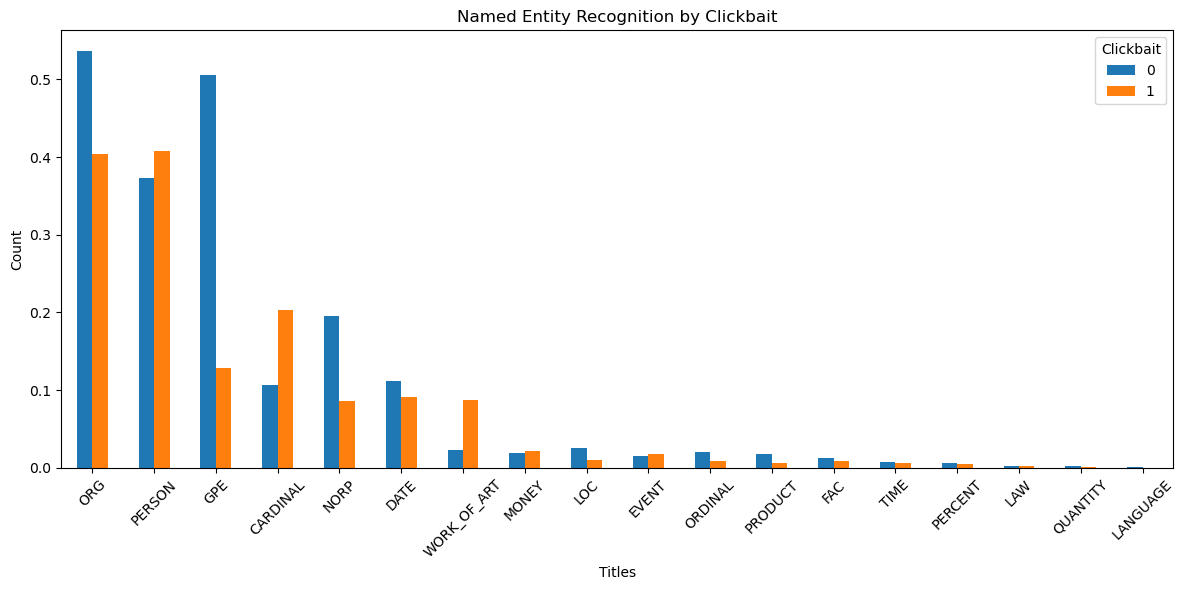

In [193]:
# NER plot
grouped.plot(kind='bar', figsize=(12, 6))
plt.title('Named Entity Recognition by Clickbait')
plt.xlabel('Titles')
plt.ylabel('Count')
plt.legend(title='Clickbait')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| **Entity**      | **Description**                                                                                  | **Example**                      |
|-----------------|--------------------------------------------------------------------------------------------------|-----------------------------------|
| **ORG**         | Organizations — refers to entities that are organizations such as companies, institutions, or agencies. | Apple, UN                        |
| **GPE**         | Geopolitical Entities — refers to entities that are geographical or political regions such as countries, cities, or states. | USA, Berlin                      |
| **PERSON**      | Person — refers to individual people or characters.                                               | Barack Obama, Elon Musk           |
| **CARDINAL**    | Numerals that do not fall under other numeric types.                                              | three, 1,000                     |
| **NORP**        | Nationalities, religious or political groups.                                                     | American, Christian, Democrat     |
| **PRODUCT**     | Objects, vehicles, foods, etc., that are products.                                                | iPhone, Boeing 737                |
| **DATE**        | Absolute or relative dates or periods.                                                            | July 4th, next week               |
| **ORDINAL**     | First, second, etc.                                                                               | first, third                     |
| **PERCENT**     | Percentage (including the “%” sign).                                                             | 50%, ten percent                 |
| **FAC**         | Facilities — buildings, airports, highways, bridges, etc.                                         | Eiffel Tower, JFK Airport         |
| **EVENT**       | Named events.                                                                                     | Olympics, World War II            |
| **WORK_OF_ART** | Titles of books, songs, etc.                                                                      | The Mona Lisa, The Catcher in the Rye |
| **TIME**        | Times smaller than a day.                                                                         | 2 PM, morning                    |
| **MONEY**       | Monetary values, including unit.                                                                  | $500, €20 million                |
| **LOC**         | Locations that are not geopolitical entities, like mountain ranges, bodies of water, etc.         | Mount Everest, Pacific Ocean      |
| **LAW**         | Named documents made into laws.                                                                   | First Amendment, The Constitution |
| **QUANTITY**    | Measurements, as of weight or distance.                                                           | 7kg, 200 miles                   |
| **LANGUAGE**    | Any named language.                                                                               | English, Spanish                 |

## Sentiment Analysys
The ***polarity*** score is a float within the range [-1.0, 1.0]. Results close to -1 are negative texts while texts close to 1 are positive one. </br>
The ***subjectivity*** is a float within the range [0.0, 1.0] where 0 is objective and 1.0 is subjective.

In [143]:
sa_train_merged = train_merged
sa_train_merged["polarity"] = sa_train_merged["title"].apply(lambda title: TextBlob(title).sentiment.polarity)
sa_train_merged["subjectivity"] = sa_train_merged["title"].apply(lambda title: TextBlob(title).sentiment.subjectivity)

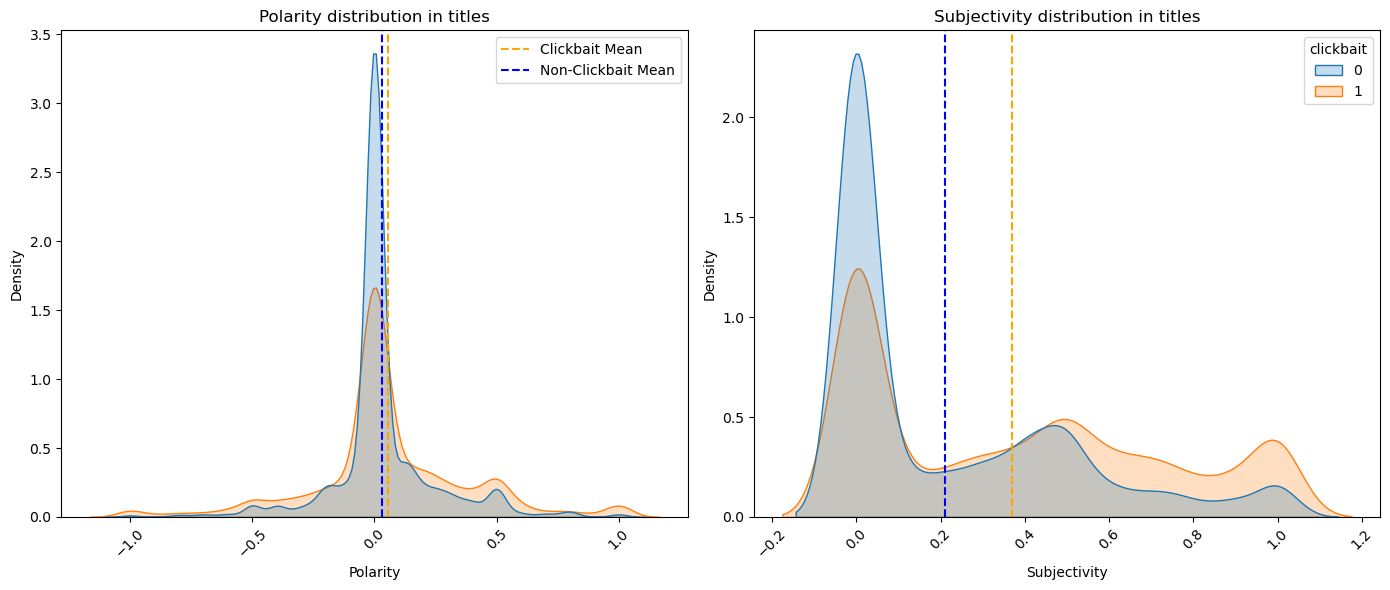

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

clickbait_means = sa_train_merged[["subjectivity", "polarity", "clickbait"]].groupby("clickbait").mean()

sns.kdeplot(data=sa_train_merged[["polarity", "clickbait"]], x="polarity", hue="clickbait", fill=True, bw_adjust=1, ax=axes[0])
axes[0].axvline(clickbait_means.loc[1, 'polarity'], color='orange', linestyle='--', label='Clickbait Mean')
axes[0].axvline(clickbait_means.loc[0, 'polarity'], color='blue', linestyle='--', label='Non-Clickbait Mean')
axes[0].set_xlabel("Polarity")
axes[0].set_ylabel("Density")
axes[0].set_title("Polarity distribution in titles")
axes[0].tick_params(axis='x', rotation=45)

sns.kdeplot(data=sa_train_merged[["subjectivity", "clickbait"]], x="subjectivity", hue="clickbait", fill=True, bw_adjust=1, ax=axes[1])
axes[1].axvline(clickbait_means.loc[1, 'subjectivity'], color='orange', linestyle='--', label='Clickbait Mean')
axes[1].axvline(clickbait_means.loc[0, 'subjectivity'], color='blue', linestyle='--', label='Non-Clickbait Mean')
axes[1].set_xlabel('Subjectivity')
axes[1].set_ylabel('Density')
axes[1].set_title("Subjectivity distribution in titles")
axes[1].tick_params(axis='x', rotation=45)

axes[0].legend()

plt.tight_layout()
plt.show()


### Sentiment Analysis conclusions:
Both clickbait and non-clickbait articles have polarity centered around 0. However, clickbaits articles distribution has heavier tails. Clickbait articles have greater values for subjectivity than non-clickbait. There is a significant difference in means.
It shows that semantics of clickbait titles is extreme more often than in valuable titles. Text might be either strongly negative or positive. Clickbait titles are also more subjective.